Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2023-04-01 по 2023-04-07 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Ваша задача — проанализировать данные АB-теста. 

1. Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
2. Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали? 
3. Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
4. Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

In [1]:
# Загружаю необходимые библиотеки.

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pandahouse

from scipy import stats

In [2]:
# Соединение.

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230420'
}

In [3]:
# Считаю количество лайков и просмотров на юзера, ctr.

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-04-01' and '2023-04-07'
    and exp_group in (1, 2)
GROUP BY exp_group, user_id
"""

In [4]:
# Выгружаю данные в пандовский датафрейм.

df = pandahouse.read_clickhouse(q, connection=connection)

In [5]:
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


In [6]:
# Распределение пользователей по группам.

df \
    .groupby('exp_group', as_index = False) \
    .user_id.count()

,exp_group,user_id
0,1,10079
1,2,9952


В группы 1 и 2 попало примерно одинаковое количество пользователей.

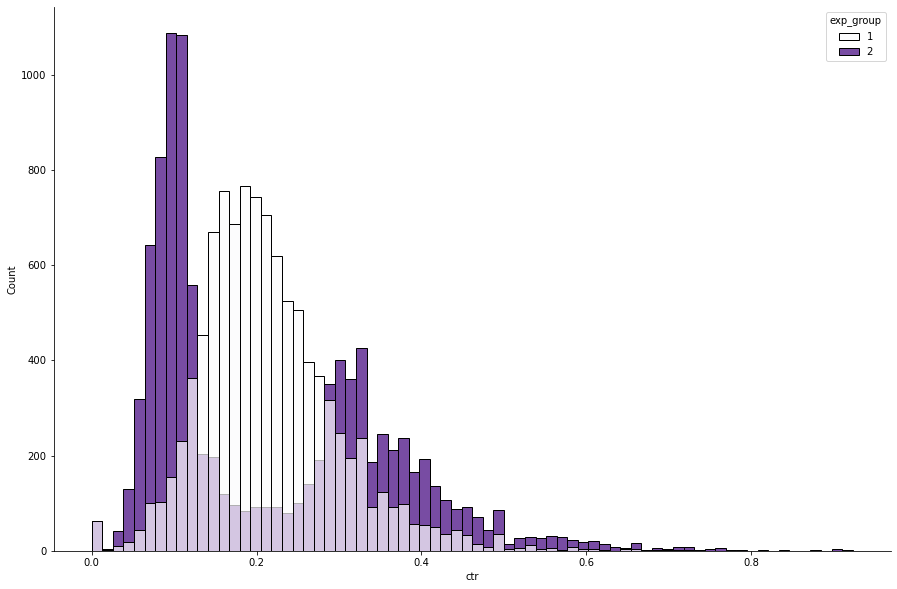

In [7]:
# Распределение метрики CTR для двух групп.

plt.figure(figsize=(15, 10))

sns.histplot(data = df, x='ctr', hue='exp_group', palette='Purples', alpha=0.7)
sns.despine()
plt.show()

Распределение метрики ctr у группы 2 бимодальное - отчетливо видны два пика(моды), а также длинный правый хвост. Распределение метрики ctr у группы 1 нормальное - распределение имеет 1 моду и является симметричным. 

Подобное распределение у группы 1 может быть связано со следующим:
1. Для группы 2 характерен более длинный правый хвост - если посмотреть на распределение количества лайков, то видно, что из группы 2 большее количество людей ставило более 60 лайков. 
2. Также в группе 2 было больше пользователей, которые поставили около 5 лайков в сравнении с группой 1.


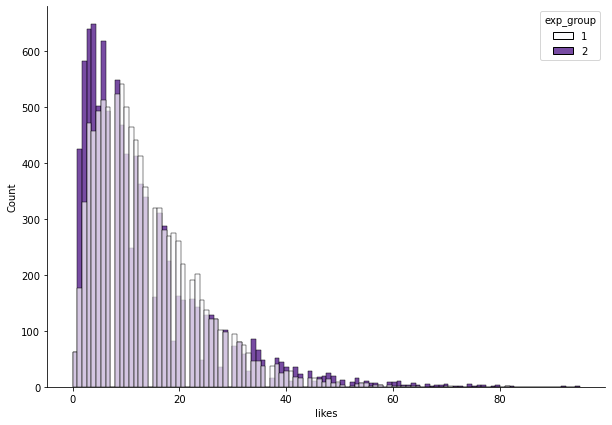

In [8]:
# Распределение лайков для двух групп.

plt.figure(figsize=(10, 7))

sns.histplot(data=df, x='likes', hue='exp_group', palette='Purples', alpha=0.7)
sns.despine()
plt.show()

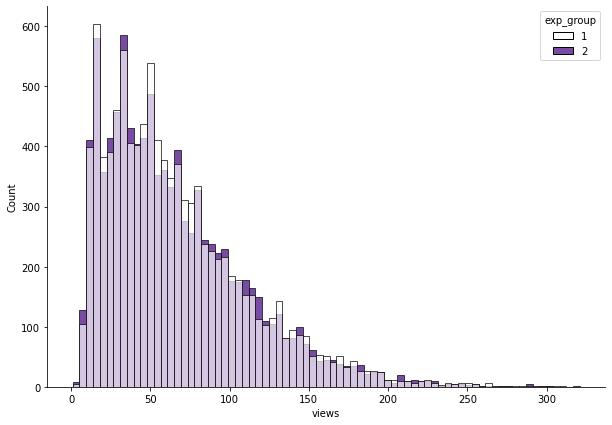

In [9]:
# Распределение количества просмотров для двух групп.

plt.figure(figsize=(10, 7))

sns.histplot(data=df, x='views', hue='exp_group', palette='Purples', alpha=0.7)
sns.despine()
plt.show()

#### t-критерий Стьюдента

Я бы не стала опираться на результаты t-testa с выборками, одна из которых(группа 2) имеет явное бимодальное распределение, длинный правый хвост и большой разброс значений(дисперсия тоже будет большой) -> смещенная оценка среднего значения. 

И, судя по графику, среднее значение второй выборки(группа 1) приблизительно соответствует среднему значению выборки с бимодальным распределением(группа 2).
Проверю этo предположение.

In [10]:
# Нормальное распределение группа 1

df[df.exp_group == 1].ctr.median()

0.203125

In [11]:
# Нормальное распределение группа 1

df[df.exp_group == 1].ctr.mean()

0.21560459841296403

In [12]:
# Бимодальное распределение группа 2

df[df.exp_group == 2].ctr.median()

0.1428571428571428

In [13]:
# Бимодальное распределение группа 2

df[df.exp_group == 2].ctr.mean()

0.21441927347479056

Медиана и среднее значение группы 2 отличаются.

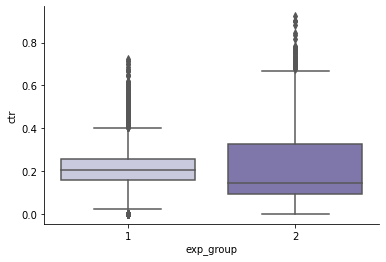

In [14]:
sns.boxplot(data=df, x="exp_group", y="ctr", palette='Purples')
sns.despine()

Действительно 1.5  × IQR группы 2 больше и включает в себя 1.5 × IQR группы 1.

In [15]:
# t-test для наглядности.
# H0: μ1 = μ2
# H1: μ1 != μ2

stat, p = stats.ttest_ind(df[df.exp_group == 1].ctr, df[df.exp_group == 2].ctr, equal_var=False)

if p >= 0.05:
    print(f'p-value = {p}, \nпри α = 0.05 мы не можем отклонить H0 о равенстве средних значений.')
else:
    print(f'p-value = {p}, \nпри α = 0.05 были обнаружены статистически значимые различия средних значений двух групп.')

p-value = 0.4780623130874935, 
при α = 0.05 мы не можем отклонить H0 о равенстве средних значений.


####  тест Манна-Уитни

In [16]:
# H0: P(X>Y) = P(Y>X)
# H1: P(X>Y) != P(Y>X)

stat, p = stats.mannwhitneyu(df[df.exp_group == 1].ctr, df[df.exp_group == 2].ctr, alternative='two-sided')

if p >= 0.05:
    print(f'p-value = {p}, \nпри α = 0.05 мы не можем отклонить H0')
else:
    print(f'p-value = {p}, \nпри α = 0.05 принимаем альтернативную гипотезу')    

p-value = 6.0376484617779035e-56, 
при α = 0.05 принимаем альтернативную гипотезу


Подведем промежуточный вывод: два теста дали нам противоположные результаты. \
t-критерий Стьюдента не позволил нам отклонить H0 о равенстве средних значений (стоит учитывать, что для t-теста не были выполнены условия его использования), в то время как согласно тесту Манна-Уитни мы должны принять альтернативную гипотезу.

#### t-тест Стьюдента на сглаженном ctr (α=5)

In [17]:
# Расчет глобальных ctr для групп 1 и 2.

global_ctr_1 = df[df.exp_group == 1].likes.sum() / df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum() / df[df.exp_group == 2].views.sum()

In [18]:
# Объявляю функцию для расчета сглаженного ctr.

def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [19]:
# Расчет сглаженного ctr.

sm_ctr1 = pd.Series(get_smothed_ctr(df[df.exp_group == 1].likes, df[df.exp_group == 1].views, global_ctr_1, 5), name='ctr')

sm_ctr2 = pd.Series(get_smothed_ctr(df[df.exp_group == 2].likes, df[df.exp_group == 2].views, global_ctr_2, 5), name='ctr')

In [20]:
# Подготовка данных для визуализации сырых значений ctr и сглаженных для группы 2 (бимодальное распределение).

In [21]:
row_ctr2 = df[df.exp_group == 2][['ctr']]
row_ctr2 = row_ctr2.assign(method = 'row')
row_ctr2.head()

,ctr,method
5,0.104478,row
6,0.080460,row
7,0.108911,row
8,0.203125,row
9,0.444444,row


In [22]:
sm_ctr2 = sm_ctr2.to_frame()
sm_ctr2 = sm_ctr2.assign(method='sm')
sm_ctr2.head()

,ctr,method
5,0.107844,sm
6,0.086851,sm
7,0.113116,sm
8,0.202935,sm
9,0.431477,sm


In [23]:
concatenated_2 = pd.concat([row_ctr2, sm_ctr2])

In [24]:
concatenated_2.reset_index(drop=True, inplace=True)

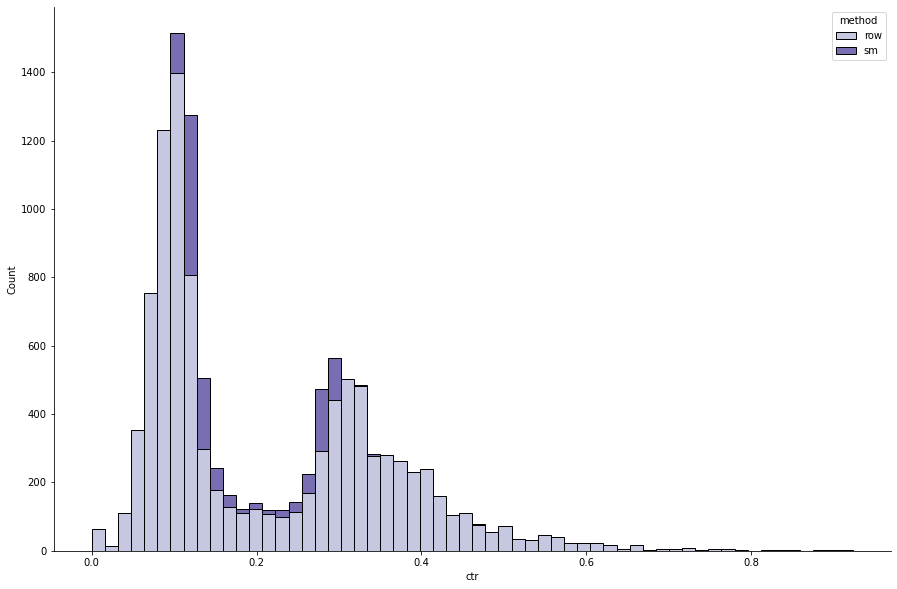

In [25]:
# Визуализация сырых значений ctr и сглаженных для группы 2.

plt.figure(figsize=(15, 10))

sns.histplot(data=concatenated_2, x='ctr', hue='method', palette='Purples', alpha=1)
sns.despine()

Данные действительно "сгладились", распределения в обоих случаях явно бимодальные ("сглаживание" не повлияло на характер распределения).

In [26]:
# t-test на сглаженном ctr.
# H0: μ1 = μ2
# H1: μ1 != μ2

stat, p = stats.ttest_ind(sm_ctr1, sm_ctr2.ctr, equal_var=False)

if p >= 0.05:
    print(f'p-value = {p}, \nпри α = 0.05 мы не можем отклонить H0 о равенстве средних значений.')
else:
    print(f'p-value = {p}, \nпри α = 0.05 были обнаружены статистически значимые различия средних значений двух групп.')

p-value = 0.0223769815558559, 
при α = 0.05 были обнаружены статистически значимые различия средних значений двух групп.


<AxesSubplot:xlabel='method', ylabel='ctr'>

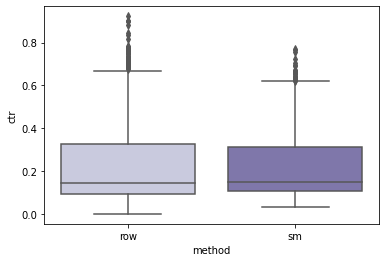

In [27]:
# Сравнения описательных статистик распределения сырых данных и сглаженных для группы 2.

sns.boxplot(data=concatenated_2, x='method', y='ctr', palette='Purples')

Результат t-теста на сглаженном ctr дал противоположный результат t-тесту на сырых данных.

Следует отметить, что после преобразования, для группы 2 форма распределения осталась прежней. Сгладились длинный правый хвост и левый, сглаженный данные содержат меньше выбросов, уменьшился межквартильный размах.

#### Пуассоновский бутстреп

In [28]:
# Объявляю функцию.

def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1) / (poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1) / (poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

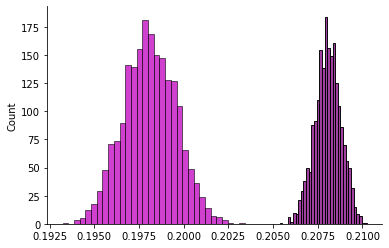

In [29]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1, color='purple')
sns.histplot(ctr2, color='m')
sns.despine()
plt.show()

Распределения ctr не перекрываются -> можно сделать вывод о том, что есть статистически значимые различия в значениях ctr у сравниваемых групп.

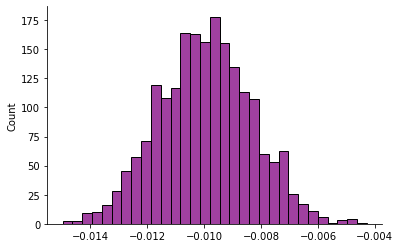

In [30]:
# разница между глобальными ctr.

sns.histplot(ctr2-ctr1, color='purple')
sns.despine()
plt.show()

#### Бакетное преобразование

In [31]:
# Бакетное преобразование. Выгружаю данные в пандовский датафрейм.

q_bucket = """
SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-04-01' and '2023-04-07'
        and exp_group in (1, 2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_bucket = pandahouse.read_clickhouse(q_bucket, connection=connection)

In [32]:
df_bucket.head()

,exp_group,bucket,bucket_ctr,ctr9
0,1,0,0.196481,0.307692
1,2,0,0.194262,0.384615
2,1,1,0.211887,0.318182
3,2,1,0.215328,0.467742
4,1,2,0.206271,0.322314


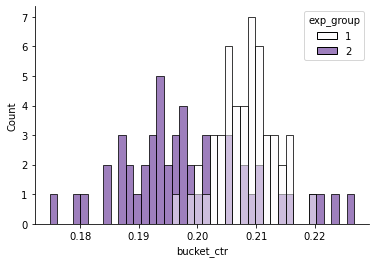

In [33]:
# Распределение бакетного ctr по группам.

sns.histplot(data=df_bucket, x='bucket_ctr', hue='exp_group', bins=40, palette='Purples')
sns.despine()
plt.show()

После бакетного преобразования распределение и у группы 2 (до преобразования распределение было бимодальным) является унимодальным и больше похоже на симметричное.
Стоит отметить, что у группы 2 также после преобразования не наблюдается длинного правого хвоста распределения.
Размах данных также сохраняется бОльшим в сравнении с группой 1.

In [34]:
#тест Манна-Уитни.
# H0: P(X>Y) = P(Y>X)
# H0: P(X>Y) != P(Y>X)


stat, p = stats.mannwhitneyu(df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                             df_bucket[df_bucket.exp_group == 2].bucket_ctr, 
                             alternative = 'two-sided')

if p >= 0.05:
    print(f'p-value = {p}, \nпри α = 0.05 мы не можем отклонить H0')
else:
    print(f'p-value = {p}, \nпри α = 0.05 принимаем альтернативную гипотезу')  

p-value = 2.859963936492646e-07, 
при α = 0.05 принимаем альтернативную гипотезу


In [35]:
# t-test.
# H0: μ1 = μ2
# H0: μ1 != μ2

stat, p = stats.ttest_ind(df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                          df_bucket[df_bucket.exp_group == 2].bucket_ctr, 
                          alternative='two-sided', equal_var=False)

if p >= 0.05:
    print(f'p-value = {p}, \nпри α = 0.05 мы не можем отклонить H0 о равенстве средних значений.')
else:
    print(f'p-value = {p}, \nпри α = 0.05 были обнаружены статистически значимые различия средних значений двух групп.')

p-value = 3.4455951649945907e-07, 
при α = 0.05 были обнаружены статистически значимые различия средних значений двух групп.


После бакетного преобразования оба теста нашли статистически значимые отличия при уровне значимости 0.05.

### Вывод

**Результаты тестов**

| тест                                             | p-value | вывод        |
|--------------------------------------------------|---------|--------------|
| t-тест                                           | 0.478   | принимаем H0 |
| тест Манна-Уитн                                  | <<0.05  | отклоняем H0 |
| t-тест на сглаженном ctr                         | 0.023   | отклоняем H0 |
| Пуассоновский бутстреп                           | <<0.05  | отклоняем H0 |
| t-тест поверх бакетного преобразования           | <<0.05  | отклоняем H0 |
| тест Манна-Уитни поверх бакетного преобразования | <<0.05  | отклоняем H0 |

Несмотря на то что 5 из 6 тестов позволяют отклонить H0 об отсутствии разницы между группами 1 и 2, я бы не стала рекомендовать внедрять новый алгоритм рекомендаций постов на всех пользователей. В сторону такого решения меня склоняет неоднозначный характер распределения ctr у группы 2. Если посмотреть на диаграмму рассеяния, то видны **два** паттерна поведения пользователей (два кластера, внутри них линейная зависимость). На одной части пользователей из группы 2 новый алгоритм показывает хорошие результаты: на меньшее количество просмотренных постов пользователи ставят большее количество лайков. На другой части пользователей новый алгоритм показывает удручающие результаты. В уравнении явно есть третья неочевидная переменная (возможно часть пользователей из группы 2 попали в другой эксперимент, который проводится параллельно нашему, в итоге мы наблюдаем смешанный эффект от использования двух новых функциональностей + к такой мысли натолкнуло отсутствие разницы в поведения пользователей в разрезах источника трафика, операционной платформы, страны, гендера (графики ниже)), в итоге, если развернуть этот алгоритм рекомендации постов на всех пользователей, мы не сможем предугадать конечный результат и эффект на другие метрики приложения. 



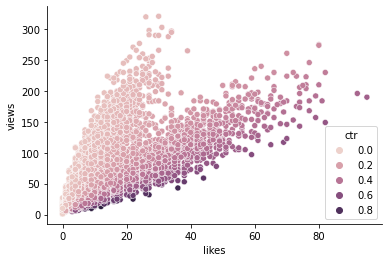

In [36]:
# Диаграмма рассеяния для группы 2.

sns.scatterplot(data=df[df.exp_group == 2], x='likes', y='views', hue='ctr')

sns.despine()
plt.show()

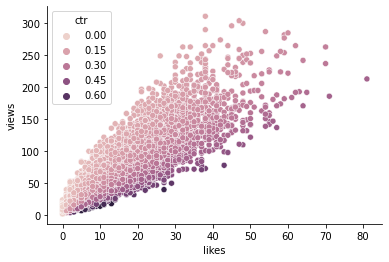

In [37]:
# Диаграмма рассеяния для группы 1.

sns.scatterplot(data=df[df.exp_group == 1], x='likes', y='views', hue='ctr')

sns.despine()
plt.show()

Дополнительно.

In [38]:
# Юзеры в разных срезах.

q_all = """
SELECT exp_group, 
    user_id, gender, age, country, os, source,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-04-01' and '2023-04-07'
        and exp_group in (1, 2)
GROUP BY exp_group, user_id, gender, age, country, os, source
"""

df_all = pandahouse.read_clickhouse(q_all, connection=connection)


Смотрю на юзеров из группы 2 в разных срезах.

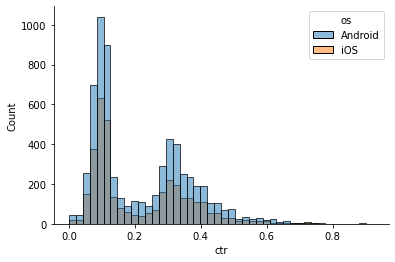

In [39]:
# OS.

sns.histplot(data=df_all[df_all.exp_group == 2], x='ctr', hue='os')
sns.despine()
plt.show()

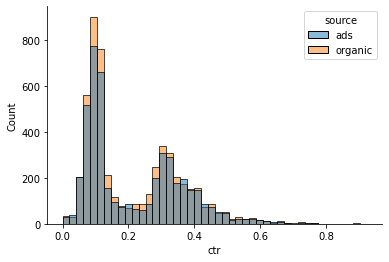

In [40]:
# Source.

sns.histplot(data=df_all[df_all.exp_group == 2], x='ctr', hue='source')
sns.despine()
plt.show()

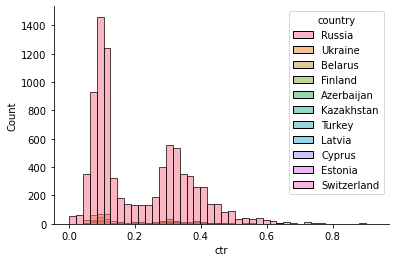

In [41]:
# Country.

sns.histplot(data=df_all[(df_all.exp_group == 2)], x='ctr', hue='country')
sns.despine()
plt.show()

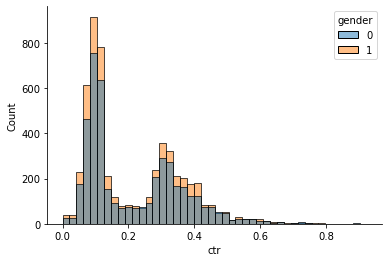

In [42]:
# Gender.

sns.histplot(data=df_all[df_all.exp_group == 2], x='ctr', hue='gender')
sns.despine()
plt.show()

Вывод: явного дисбаланса по рассмотренным срезам нет.